In [1]:
# Import necessary libraries
import pandas as pd
import re
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import joblib


In [2]:
# Load the dataset
file_path = 'D:/chatbot.xlsx'  # Replace with your dataset's path
data = pd.read_excel(file_path)

In [3]:
# Clean the text data
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing spaces
    return text

data['cleaned_utterance'] = data['utterance'].apply(clean_text)

In [4]:
# Split dataset into features (X) and labels (y)
X = data['cleaned_utterance']
y = data['intent']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [5]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [6]:
# Label Encoding for intents
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [7]:
# Save the vectorizer and label encoder for later use
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

In [8]:
# Initialize XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model on the training data
model.fit(X_train_tfidf, y_train_encoded)

# Save the trained model for later use
joblib.dump(model, 'chatbot_intent_model_xgboost.pkl')


C:\Users\praty\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [06:10:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['chatbot_intent_model_xgboost.pkl']

Validation Classification Report:
                          precision    recall  f1-score   support

            cancel_order       0.96      0.98      0.97        46
            change_order       1.00      0.98      0.99        45
 change_shipping_address       0.98      1.00      0.99        45
  check_cancellation_fee       0.94      1.00      0.97        45
           check_invoice       0.96      1.00      0.98        48
   check_payment_methods       0.98      1.00      0.99        45
     check_refund_policy       1.00      1.00      1.00        45
               complaint       1.00      1.00      1.00        45
contact_customer_service       1.00      1.00      1.00        45
     contact_human_agent       0.98      1.00      0.99        44
          create_account       0.98      0.98      0.98        45
          delete_account       0.94      0.98      0.96        45
        delivery_options       1.00      0.98      0.99        45
         delivery_period       1.00      

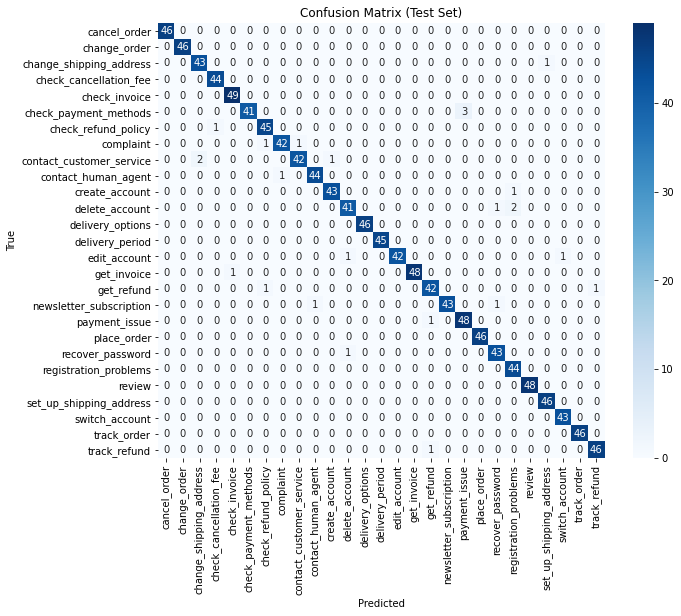

In [9]:
# Evaluate the model on the validation set
y_val_pred = model.predict(X_val_tfidf)
print("Validation Classification Report:")
print(classification_report(y_val_encoded, y_val_pred, target_names=label_encoder.classes_))

# Evaluate the model on the test set
y_test_pred = model.predict(X_test_tfidf)
print("Test Classification Report:")
print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()


In [13]:
import random

# Example response dictionary with multiple responses per intent
responses = {
    'cancel_order': [
        "I can help you with that. Please provide your order number.",
        "To cancel your order, I need the order number. Can you share it?",
        "I’m here to assist with your cancellation. Please provide the order number.",
        "Sure! Can you tell me the order number you'd like to cancel?"
    ],
    'track_order': [
        "Please share your order number so I can track it for you.",
        "I’ll help you track your order. What’s the order number?",
        "Could you give me your order number to track it for you?",
        "I can track your order. Please share the order number."
    ],
    'create_account': [
        "Let's get started with creating your account. What's your name?",
        "I’m ready to help you create your account. Can you tell me your name?",
        "I can assist you in creating a new account. What’s your name?",
        "Can you please share your name to create your account?"
    ],
    'payment_issue': [
        "What issue are you facing with the payment? Let me assist you.",
        "Could you please tell me the payment issue you're encountering?",
        "Let me help you resolve the payment issue. What exactly happened?",
        "Please describe the payment issue you're facing, and I'll assist you."
    ],
    'refund_status': [
        "Can you provide your order number so I can check the refund status?",
        "Please provide the order ID to check your refund status.",
        "Let me check the refund status for you. Can you share your order number?"
    ],
    # Add more intents and responses as needed
}

# Function to get a random response based on predicted intent
def chatbot_response(user_input):
    # Clean and preprocess the input
    cleaned_input = clean_text(user_input)
    user_input_tfidf = tfidf_vectorizer.transform([cleaned_input])

    # Predict the intent using the trained XGBoost model
    predicted_intent_idx = model.predict(user_input_tfidf)[0]
    predicted_intent = label_encoder.inverse_transform([predicted_intent_idx])[0]

    # Get a random response for the predicted intent
    response = random.choice(responses.get(predicted_intent, ["Sorry, I didn't understand that. Can you rephrase?"]))
    return response

# Allow the user to input queries in a loop
def start_chat():
    print("Chatbot: Hello! How can I assist you today?")
    
    while True:
        user_input = input("You: ")  # Take input from the user
        if user_input.lower() in ['exit', 'quit', 'bye']:
            print("Chatbot: Goodbye! Have a nice day!")
            break  # Exit the loop if the user types 'exit', 'quit', or 'bye'
        
        # Get chatbot response and print it
        response = chatbot_response(user_input)
        print(f"Chatbot: {response}")

# Start the chat
start_chat()


Chatbot: Hello! How can I assist you today?
You: if i cancel my order can i get refund
Chatbot: Sorry, I didn't understand that. Can you rephrase?
You: how can i cancel my order
Chatbot: I can help you with that. Please provide your order number.
You: cancel order
Chatbot: Sure! Can you tell me the order number you'd like to cancel?
You: create account
Chatbot: Can you please share your name to create your account?
You: create account
Chatbot: I can assist you in creating a new account. What’s your name?
You: If my order is delayed, can I cancel it?
Chatbot: Sure! Can you tell me the order number you'd like to cancel?
You: If I cancel my order, will I get a refund?
Chatbot: Sorry, I didn't understand that. Can you rephrase?


KeyboardInterrupt: Interrupted by user